In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Load all datasets
train_proteins = pd.read_csv("./input/train_proteins.csv")
train_clinical = pd.read_csv("./input/train_clinical_data.csv")
train_peptides = pd.read_csv("./input/train_peptides.csv")
supplemental_clinical = pd.read_csv("./input/supplemental_clinical_data.csv")

In [3]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [4]:
# Pivot the proteins and peptides tables so each protein and peptide is a feature
train_proteins = train_proteins.pivot_table(values="NPX", index="visit_id", columns="UniProt")
train_peptides = train_peptides.pivot_table(values="PeptideAbundance", index="visit_id", columns="Peptide")

In [5]:
# Merge the three tables
train = train_clinical.merge(train_proteins, on="visit_id", how="left")  \
                      .merge(train_peptides, on="visit_id", how="left")

In [6]:
# Set the patient id as index
train = train.set_index(["patient_id"])

In [7]:
# An overview of the new tables
train.head(20)

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,55_0,0,10.0,6.0,15.0,NaN,NaN,11254.30,732430.0,39585.8,...,201158.0,16492.30,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
55,55_3,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_6,6,8.0,10.0,34.0,NaN,NaN,13163.60,630465.0,35220.8,...,171079.0,13198.80,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
55,55_9,9,8.0,9.0,30.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_12,12,10.0,10.0,41.0,0.0,On,15257.60,815083.0,41650.9,...,231772.0,17873.80,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
55,55_18,18,7.0,13.0,38.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_24,24,16.0,9.0,49.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_30,30,14.0,13.0,49.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_36,36,17.0,18.0,51.0,0.0,On,13530.80,753832.0,43048.9,...,185290.0,18580.50,2659660.0,90936.9,679163.0,128593.0,203680.0,498621.0,52792.7,13973.7


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 55 to 65043
Columns: 1202 entries, visit_id to YYWGGQYTWDMAK
dtypes: float64(1199), int64(1), object(2)
memory usage: 24.0+ MB


In [9]:
train = train.drop("visit_id", axis=1)

In [10]:
# Create a list of the ids of the patients
patient_id = list(train.index.unique())

In [11]:
# Check missing values
print(train.isna().sum().sum())

1962306


In [12]:
# Interpolate the missing data of every patient
for patient in patient_id:
    train.loc[patient] = train.loc[patient].interpolate(method="linear").fillna(method="bfill")

In [13]:
# Fill updrs and state of medication values
train.updrs_4 = train.updrs_4.fillna(0)
train.upd23b_clinical_state_on_medication = train.upd23b_clinical_state_on_medication.fillna("Off")

In [14]:
# Adjust updr4 values to possible values
train.updrs_4 = round(train.updrs_4)

In [15]:
# Check missing values after interpolate
print("Total missing values left: {}".format(train.isna().sum().sum()))
print(train.isna().sum().sort_values(ascending=False))

Total missing values left: 80927
EPQVYTLPPSRDELTK                                       1230
ALVQQMEQLR                                              778
AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR     741
HYEGSTVPEK                                              683
QQLVETHMAR                                              662
                                                       ... 
C(UniMod_4)LAFEC(UniMod_4)PENYRR                          0
NANTFISPQQR                                               0
C(UniMod_4)LKDGAGDVAFVK                                   0
MYLGYEYVTAIR                                              0
visit_month                                               0
Length: 1201, dtype: int64


In [16]:
# Fill the remaining na values with the mean of the columns
train = train.fillna(train.mean())

In [17]:
train.head(20)

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,10.0,6.0,15.0,0.0,On,11254.300000,732430.00,39585.80,41526.900,...,201158.00,16492.300,3810270.0,106894.000,580667.0,131155.000,165851.000,437305.0,46289.200,14898.400000
55,3,10.0,7.0,25.0,0.0,On,12208.950000,681447.50,37403.30,41410.950,...,186118.50,14845.550,3964895.0,110139.500,547764.0,117333.500,155229.000,447598.0,43168.450,17801.150000
55,6,8.0,10.0,34.0,0.0,On,13163.600000,630465.00,35220.80,41295.000,...,171079.00,13198.800,4119520.0,113385.000,514861.0,103512.000,144607.000,457891.0,40047.700,20703.900000
55,9,8.0,9.0,30.0,0.0,On,14210.600000,722774.00,38435.85,40529.150,...,201425.50,15536.300,4796830.0,114835.500,613338.0,120227.500,163185.000,455072.0,47386.400,21272.500000
55,12,10.0,10.0,41.0,0.0,On,15257.600000,815083.00,41650.90,39763.300,...,231772.00,17873.800,5474140.0,116286.000,711815.0,136943.000,181763.000,452253.0,54725.100,21841.100000
55,18,7.0,13.0,38.0,0.0,On,14825.900000,799770.25,42000.40,40698.375,...,220151.50,18050.475,4770520.0,109948.725,703652.0,134855.500,187242.250,463845.0,54242.000,19874.250000
55,24,16.0,9.0,49.0,0.0,On,14394.200000,784457.50,42349.90,41633.450,...,208531.00,18227.150,4066900.0,103611.450,695489.0,132768.000,192721.500,475437.0,53758.900,17907.400000
55,30,14.0,13.0,49.0,0.0,On,13962.500000,769144.75,42699.40,42568.525,...,196910.50,18403.825,3363280.0,97274.175,687326.0,130680.500,198200.750,487029.0,53275.800,15940.550000
55,36,17.0,18.0,51.0,0.0,On,13530.800000,753832.00,43048.90,43503.600,...,185290.00,18580.500,2659660.0,90936.900,679163.0,128593.000,203680.000,498621.0,52792.700,13973.700000


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 55 to 65043
Columns: 1201 entries, visit_month to YYWGGQYTWDMAK
dtypes: float64(1199), int64(1), object(1)
memory usage: 24.0+ MB


In [19]:
s = train.columns.values
e = ['upd23b_clinical_state_on_medication', 'visit_month']
norm_columns = set(train.columns.values)-set(e)
print(len(set(train.columns.values)))
print(len(set(train.columns.values)-set(e)))

1201
1199


In [20]:
# Now we shall normalize all the columns values with the exception of two columns
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']
for col in norm_columns:
    train[col] = (train[col] - train[col].min()) / (train[col].max() - train[col].min())    

train.head()

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,0.303030,0.150,0.174419,0.0,On,0.506663,0.385009,0.589438,0.577661,...,0.475128,0.592219,0.266399,0.148896,0.144114,0.519776,0.626289,0.454550,0.395872,0.202879
55,3,0.303030,0.175,0.290698,0.0,On,0.553258,0.355831,0.555836,0.575605,...,0.437318,0.532145,0.277691,0.153454,0.135841,0.464635,0.585936,0.465535,0.364930,0.244856
55,6,0.242424,0.250,0.395349,0.0,On,0.599854,0.326652,0.522234,0.573549,...,0.399509,0.472072,0.288983,0.158013,0.127568,0.409494,0.545584,0.476519,0.333988,0.286832
55,9,0.242424,0.225,0.348837,0.0,On,0.650957,0.379483,0.571733,0.559971,...,0.475800,0.557344,0.338447,0.160050,0.152329,0.476181,0.616161,0.473511,0.406751,0.295055
55,12,0.303030,0.250,0.476744,0.0,On,0.702060,0.432313,0.621233,0.546393,...,0.552091,0.642616,0.387911,0.162088,0.177089,0.542868,0.686737,0.470502,0.479514,0.303277


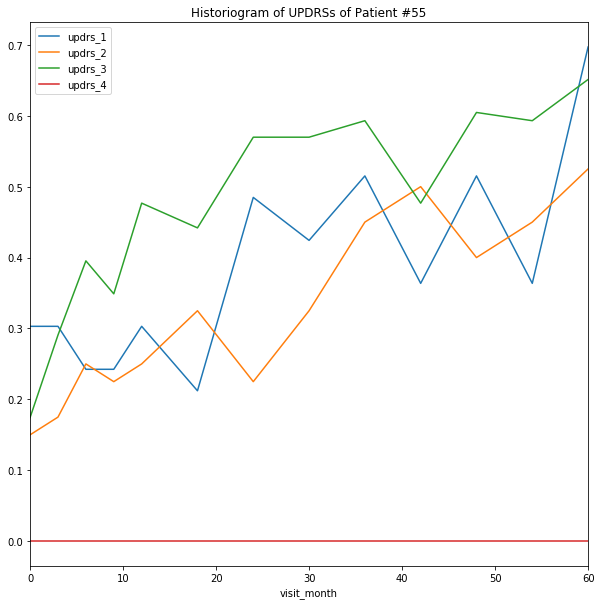

In [21]:
# We shall plot the evoltion of each updrs in time
patient = patient_id[0]
train.loc[patient].plot(x="visit_month", y=updrs_cols,
        kind="line", figsize=(10, 10))
plt.title(f'Historiogram of UPDRSs of Patient #{patient}')
plt.show() 

In [22]:
#  We shall define a linear regression method for each updrs
def linear_regressor_method(X,Y):
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    return linear_regressor

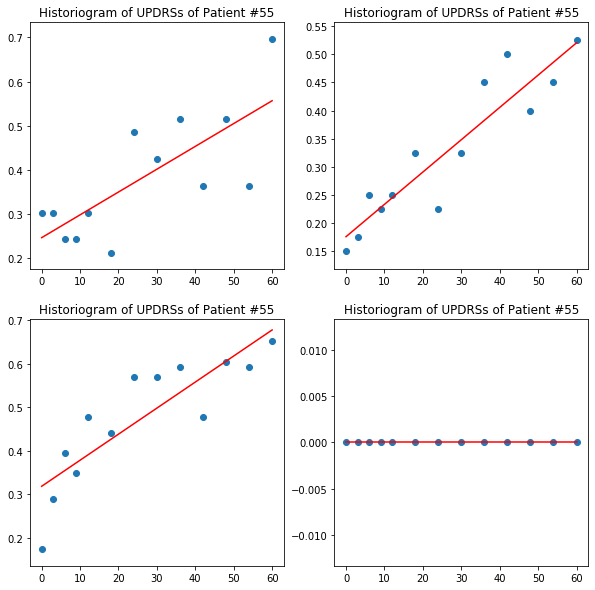

In [23]:
# Estimating updrs of one patient based on month_visit
# We shall invoke previous method 
linear_regressors_list = []
fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[patient]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[patient][updrs].values.reshape(-1, 1) 
    lr = linear_regressor_method(np_x, np_y)
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Historiogram of UPDRSs of Patient #{patient}')
    aux += 1

#TODO: Need to apply linear regression with all the proteins in the dataframe

Training set metrics:
	Training set of updrs_1 mean squared error: 0.03
	Training set of updrs_1 mean absolute error: 0.13
	Training set of updrs_1 R^2 score: 0.01
	Training set of updrs_2 mean squared error: 0.03
	Training set of updrs_2 mean absolute error: 0.13
	Training set of updrs_2 R^2 score: 0.01
	Training set of updrs_3 mean squared error: 0.03
	Training set of updrs_3 mean absolute error: 0.14
	Training set of updrs_3 R^2 score: 0.01
	Training set of updrs_4 mean squared error: 0.02
	Training set of updrs_4 mean absolute error: 0.09
	Training set of updrs_4 R^2 score: 0.03
Testing set metrics:
	Testing set of updrs_1 mean squared error: 0.03
	Testing set of updrs_1 mean absolute error: 0.12
	Testing set of updrs_1 R^2 score: 0.02
	Testing set of updrs_2 mean squared error: 0.02
	Testing set of updrs_2 mean absolute error: 0.12
	Testing set of updrs_2 R^2 score: 0.04
	Testing set of updrs_3 mean squared error: 0.03
	Testing set of updrs_3 mean absolute error: 0.14
	Testing set

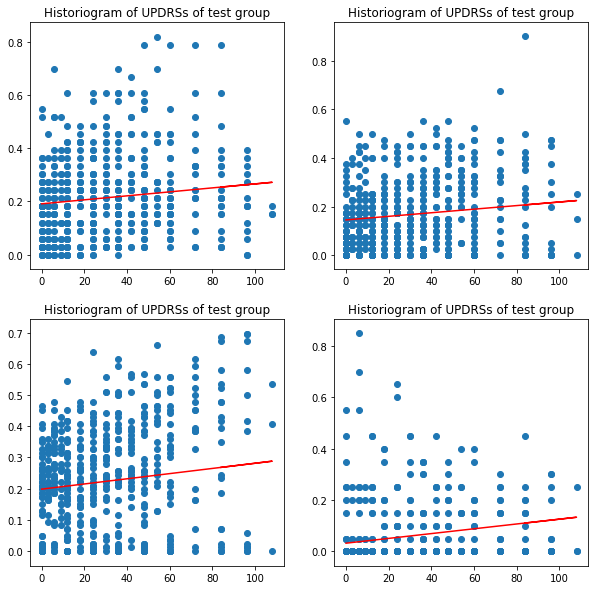

In [76]:
training_length = round(len(patient_id)*0.8)
testing_length  = len(patient_id)-round(len(patient_id)*0.8)
train_lr = patient_id[0:training_length]
test_lr  = patient_id[training_length:len(patient_id)]

linear_regressors_list = []

print('Training set metrics:')
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[train_lr]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[train_lr][updrs].values.reshape(-1, 1)
    lr = linear_regressor_method(np_x, np_y)
    org_dict = { f'{updrs}': lr }
    linear_regressors_list.append(org_dict)
    y_pred = lr.predict(np_x)
    mse_train = mean_squared_error(np_y, y_pred)
    mae_train = mean_absolute_error(np_y, y_pred)
    # mape_train = mean_absolute_percentage_error(np_y, y_pred) * 100
    r2_train = r2_score(np_y, y_pred)
    print(f"\tTraining set of {updrs} mean squared error: {mse_train:.2f}")
    print(f"\tTraining set of {updrs} mean absolute error: {mae_train:.2f}")
    # print(f"\tTraining set of {updrs} mean absolute percentage error: {mape_train:.3f} %")
    print(f"\tTraining set of {updrs} R^2 score: {r2_train:.2f}")

fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
print('Testing set metrics:')
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[test_lr]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[test_lr][updrs].values.reshape(-1, 1)
    lr   = linear_regressors_list[idx][f'{updrs}']
    # print(linear_regressors_list)
    y_pred = lr.predict(np_x)
    mse_test = mean_squared_error(np_y, y_pred)
    mae_test = mean_absolute_error(np_y, y_pred)
    # mape_test = mean_absolute_percentage_error(np_y, y_pred) * 100
    r2_test = r2_score(np_y, y_pred)
    print(f"\tTesting set of {updrs} mean squared error: {mse_test:.2f}")
    print(f"\tTesting set of {updrs} mean absolute error: {mae_test:.2f}")
    # print(f"\tTesting set of {updrs} mean absolute percentage error: {mape_test:.3f} %")
    print(f"\tTesting set of {updrs} R^2 score: {r2_test:.2f}")
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Historiogram of UPDRSs of test group')
    aux += 1


In [24]:
print(train.columns[6:])

Index(['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240',
       'O15394', 'O43505', 'O60888',
       ...
       'YSLTYIYTGLSK', 'YTTEIIK', 'YVGGQEHFAHLLILR',
       'YVM(UniMod_35)LPVADQDQC(UniMod_4)IR', 'YVMLPVADQDQC(UniMod_4)IR',
       'YVNKEIQNAVNGVK', 'YWGVASFLQK', 'YYC(UniMod_4)FQGNQFLR', 'YYTYLIMNK',
       'YYWGGQYTWDMAK'],
      dtype='object', length=1195)


In [25]:
# Now we will use a regression model to predict the updrs based on protein levels
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_1, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf1 = RandomForestRegressor()

# Fit the model to the training data
rf1.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf1.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 1:', mae)

C:\Users\vbovedap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error of updrs 1: 0.08742880793810744


In [26]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_2, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf2 = RandomForestRegressor()

# Fit the model to the training data
rf2.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf2.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 2:', mae)

C:\Users\vbovedap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error of updrs 2: 0.0725847150777839


In [27]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_3, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf3 = RandomForestRegressor()

# Fit the model to the training data
rf3.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf3.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 3:', mae)

C:\Users\vbovedap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error of updrs 3: 0.08456077344550599


In [28]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_4, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf4 = RandomForestRegressor()

# Fit the model to the training data
rf4.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf4.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 4:', mae)

C:\Users\vbovedap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error of updrs 4: 0.0586534809995613


In [29]:
print(train.updrs_1)

patient_id
55       0.303030
55       0.303030
55       0.242424
55       0.242424
55       0.303030
           ...   
65043    0.212121
65043    0.121212
65043    0.181818
65043    0.090909
65043    0.212121
Name: updrs_1, Length: 2615, dtype: float64


In [30]:
print(y_pred)

[0.095      0.055      0.         0.         0.         0.3
 0.06       0.15       0.07616667 0.         0.         0.01875
 0.165      0.08416667 0.01178571 0.095      0.015      0.099
 0.         0.025      0.225      0.015      0.035      0.025
 0.         0.         0.02       0.075      0.13       0.
 0.02766667 0.02111111 0.0125     0.01333333 0.         0.
 0.31233333 0.055      0.025      0.         0.         0.08225
 0.095      0.0625     0.16997222 0.         0.         0.07466667
 0.025      0.00125    0.         0.09       0.         0.23833333
 0.         0.035      0.17       0.035      0.03       0.095
 0.         0.         0.         0.         0.02       0.
 0.32916667 0.01       0.12       0.17833333 0.775      0.
 0.025      0.         0.19428571 0.18875    0.         0.
 0.         0.015      0.         0.545      0.         0.
 0.         0.18666667 0.         0.         0.20803571 0.22625
 0.015      0.29571429 0.         0.0815     0.05583333 0.025
 0.0075     

In [31]:
print(y_test)

patient_id
64674    0.20
24820    0.05
56317    0.00
26210    0.00
49683    0.00
         ... 
13618    0.25
60326    0.00
12931    0.00
30416    0.05
64674    0.30
Name: updrs_4, Length: 523, dtype: float64
